In [1]:
%load_ext autoreload
%autoreload 2
from fastai import * 
from fastai.text import * 
import sentencepiece as spm
import psutil


In [2]:
lang            = "en"
pathData       = Path("../nlp-data")
path           = pathData / lang
pathTrainValid = path/"wiki-train_valid"
spCache        = "sp-model"
pathSPVocab    = pathTrainValid / spCache

In [3]:
#def usedGB_RAM(): return round((psutil.virtual_memory().total-psutil.virtual_memory().free)/1e9,2)
def usedGB_RAM(): return round((psutil.virtual_memory().used + psutil.swap_memory().used)/1e9,2)


In [4]:
psutil.virtual_memory().total
usedGB_RAM()

4.67

# Data preparation

Load the training and validation data we prepared in wiki_preparation.ipynb. In total 100 million articles with a split of 80% / 20% for training/validation:
- First column: text content to train the model. 
- Second column: Boolean representing if the data is for training or validation.

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece so that fastai can use it instead of spacy

In [5]:
class SentencepieceTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        path,cache_name = pathTrainValid, "sp-model"
    #def __init__(self, path:PathOrStr, cache_name:str='sp-model'):
        self.pathVocab = path / cache_name
        self.vocab_    = Vocab(pickle.load(open(self.pathVocab/'itos.pkl', 'rb')))
        self.tok       = spm.SentencePieceProcessor()
        
        self.tok.Load(str(Path(path) / cache_name / 'm.model'))
        text.transform.UNK = "<unk>"

    #def __call__(self, language:str): return self    
        
    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
    def add_special_cases(self, toks:Collection[str]):
        #this should have been done when training sentencepiece
        pass
    
    def vocab(self): return self.vocab_

In [6]:
spt       = SentencepieceTokenizer(lang="en")
tokenizer = Tokenizer(SentencepieceTokenizer,"en")
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)

print(tokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
sentence = ["She is tall.", "He is small"]
tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


[['▁she', '▁is', '▁tall', '.'], ['▁he', '▁is', '▁small']]

# LM Training


We train two LM: one with a 60k vocabulary and one with a 30k vocabulary. The two models have different performance and computation needs.

In [7]:
#Discard section with kess than "minTok" tokens
minToks=10

In [8]:
a= [0,1,2,3.1]
json.dumps(a)
str(np.asarray(a))

'[0.  1.  2.  3.1]'

In [9]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool 

In [10]:
class FileTokenizer():
    "Put together rules and a tokenizer function to tokenize text with multiprocessing."
    def __init__(self, tokPath:Path, tok_func:Callable, lang:str, vocab:Vocab=vocab, pre_rules:ListRules=None,
                 post_rules:ListRules=None, special_cases:Collection[str]=None, n_cpus:int=None):
        self.tok_func,self.lang,self.special_cases = tok_func,lang,special_cases
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        self.post_rules = ifnone(post_rules, defaults.text_post_rules )
        self.special_cases = special_cases if special_cases else defaults.text_spec_tok
        self.n_cpus = ifnone(n_cpus, defaults.cpus)
        self.vocab  = vocab
        self.tokPath = tokPath
        
        self.count=0

    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} in {self.lang} with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        for rule in self.post_rules: res += f' - {rule.__name__}\n'
        return res

    def process_text(self, t:str, tok:BaseTokenizer) -> List[str]:
        "Process one text `t` with tokenizer `tok`."
        inPath = Path(t)
        if not inPath.exists(): 
            print(f"file does not exist{str(inPath)}")
            return ""
        
        pathIds = self.tokPath/(inPath.stem+"-ids.npy")
        pathIds.parent.mkdir(parents=True,exist_ok=True)
        
        arrays = []
        with inPath.open("r") as f:
            for line in f:
                for rule in self.pre_rules: line = rule(line)
                toks = tok.tokenizer(line)
                for rule in self.post_rules: toks = rule(toks)
                ids = vocab.numericalize(toks) 
                
                if len(toks) < minToks: continue
                arrays.append( np.asarray(ids, dtype=np.int16) )
        
        if len(arrays)>0:
            with pathIds.open("wb") as f:
                np.save(f, arrays, allow_pickle=True, fix_imports=False)
                
        return t

    def _process_all_1(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts` in one process."
        tok = self.tok_func(self.lang)
        if self.special_cases: tok.add_special_cases(self.special_cases)
        return [self.process_text(t, tok) for t in texts]

    def process_all(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts`."
        print("FileTokenizer process_all")
        
        if self.n_cpus <= 1: return self._process_all_1(texts)
        print(f"cpus: {self.n_cpus} number of files:{len(texts)}")
        with ProcessPoolExecutor(self.n_cpus) as e:
            #return e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus))
            return sum(e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus)), [])
        
    @staticmethod
    def getIds_from_file(files):
        idArrays=[]
        for fp in files:
            with fp.open("rb") as f:
                a = np.load(f)
                if len(a) > 0: idArrays.extend( a )
        return idArrays 
    
    def getIds(self, n_cpus=defaults.cpus):
        #threading does not help on speed in this case :(
        files = list(self.tokPath.glob("*-ids.npy"))
        
        #3use_cores = max(1,defaults.cpus)
        print(f"threading with on {n_cpus} cores")
        pool = ThreadPool(n_cpus) 

        results = pool.map(FileTokenizer.getIds_from_file, partition_by_cores(files, n_cpus))
        pool.close() 
        pool.join()
    
    
        idArrays=[]
        for a in results:idArrays.extend(a)
        idArrays = np.asarray(idArrays,dtype=object)    
        return idArrays 
    
    """
    def getIds(self):
        pool = ThreadPool() 

        files = list(self.tokPath.glob("*-ids.npy"))
        idArrays=[]
        for p in files:
            with p.open("rb") as f:
                a = np.load(f)
                if len(a) > 0: idArrays.extend( a )
                    
        idArrays = np.asarray(idArrays,dtype=object)    
        return idArrays 
    """
        

In [11]:
class FileTokenizeProcessor(PreProcessor):
    "`PreProcessor` that tokenizes the texts in `ds`."
    def __init__(self, ds:ItemList=None, tokenizer:Tokenizer=None, chunksize:int=10000, mark_fields:bool=False):
        self.tokenizer,self.chunksize,self.mark_fields = ifnone(tokenizer, Tokenizer()),chunksize,mark_fields

    def process_one(self, item):  return self.tokenizer._process_all_1([item])[0]
    def process(self, ds):
        print("FileTokenizeProcessor process")
        #ds.items = _join_texts(ds.items, self.mark_fields)
        self.tokenizer.process_all(ds.items)
        #ds.items = self.tokenizer.process_all(ds.items)
        #ds.items = tokens


In [12]:
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathTrainValid/"toks/train", SentencepieceTokenizer,"en",vocab)
validTokenizer = FileTokenizer(pathTrainValid/"toks/valid", SentencepieceTokenizer,"en",vocab)

print(trainTokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
#sentence = ["She is tall.", "He is small"]
#tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


In [13]:
#import timeit start = timeit.default_timer()
pathTxt = pathTrainValid/"txt"
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                     processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, chunksize=chunksize, mark_fields=False)] )
validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                     processor=[FileTokenizeProcessor(tokenizer=validTokenizer, chunksize=chunksize, mark_fields=False)] )
#print(timeit.default_timer()-start )

In [14]:
print("1 nb: used GB memory:", usedGB_RAM()) 
%time trainIDS = trainTokenizer.getIds(n_cpus=1)

1 nb: used GB memory: 4.63
threading with on 1 cores
CPU times: user 1min 49s, sys: 9.74 s, total: 1min 59s
Wall time: 2min


In [15]:
%time validIDS = validTokenizer.getIds(n_cpus=1)
gc.collect()
print("2 nb: used GB memory:", usedGB_RAM()) 

threading with on 1 cores
CPU times: user 35.6 s, sys: 5.16 s, total: 40.8 s
Wall time: 41.7 s
2 nb: used GB memory: 8.51


In [16]:
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

Traning:    number of arrays:25527730 - number of ids:2046492393
Validation: number of arrays:8504038 - number of ids:733295647


min:1 max:12985 - median:63.0
1521907


array([134,  71,  70,  16,  35,  39, 269, 261, 146,  89,  39,  43,  42,  20,  33, 132,  87,  67,  12,  36], dtype=int32)

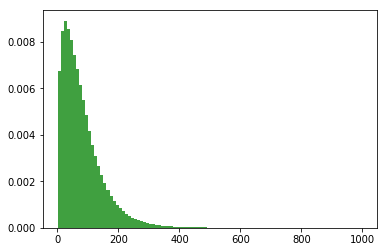

In [17]:
sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
n, bins, patches = plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print(np.sum(sectionlengths<10))
sectionlengths[:20]

In [18]:
#import traceback
def usedGB_RAM(): 
    import psutil
    return round((psutil.virtual_memory().used + psutil.swap_memory().used)/1e9,2)

#missing backwards
class MyLanguageModelLoader():
    "Create a dataloader with bptt slightly changing."
    
    class CircularIndex():
        def __init__(self, length:int ): self.idx = np.arange(length)
        #if the index exceed length then getitem wrap the key and starrt return key-len(self.idx)
        def __getitem__(self, key): return self.idx[key%len(self.idx)]
        def __len__(self) -> int: return len(self.idx)
        def shuffle(self): 
            print("shuffle")
            np.random.shuffle(self.idx)
                
    def __init__(self, dataset:LabelList, bs:int=64, bptt:int=70, backwards:bool=False, shuffle:bool=False,
                 max_len:int=25, p_bptt:int=0.95):
        self.dataset,self.bs,self.bptt,self.backwards,self.shuffle,self.p_bptt = dataset,bs,bptt,backwards,shuffle,p_bptt
        self.idx        = MyLanguageModelLoader.CircularIndex(len(self.dataset))
        #self.idx        = np.arange(len(self.dataset))
        self.ragLengths = np.asarray([len(s) for s in dataset.x.items],dtype=np.int) if len(dataset.x.items) > 0 else []
        self.nToks      = np.sum(self.ragLengths)
        
        self.min_seq,self.max_seq = 5,max_len
        self.num_workers = 0
        self.init_kwargs = dict(bs=bs, bptt=bptt, backwards=backwards, shuffle=shuffle, max_seq=max_len)

        print(f"LanguageModelLoader.__init__ - used GB memory: {usedGB_RAM()} length of dataset:{len(self.ragLengths)} "+\
              f"\nnToks:{self.nToks} bptt:{self.bptt} max_seq:{self.max_seq} shuffle:{self.shuffle}" )  
        
    def __iter__(self):
        if getattr(self.dataset, 'item', None) is not None: 
            yield LongTensor(getattr(self.dataset, 'item'))[None],LongTensor([0])
        if self.shuffle: 
            self.idx.shuffle()
            #np.random.shuffle(self.idx)

        #print(f"LanguageModelLoader.__iter__ - used GB memory: {usedGB_RAM()} length of dataset:{len(self.ragLengths)} "+\
        #      f"nToks:{self.nToks} bptt:{self.bptt} max_seq:{self.max_seq}" )  
        
        self.offset,self.ei,self.eo  = 0,0,1
        while self.offset + self.min_seq*self.bs < self.nToks-1:
            if self.offset==0: 
                seq_len = self.bptt + self.max_seq
            else:
                bptt    = self.bptt if np.random.random() < self.p_bptt else self.bptt / 2.
                seq_len = max(self.min_seq, int(np.random.normal(bptt, 5)))
                seq_len = min(seq_len,      self.bptt + self.max_seq)
                
            res, seq_len = self.get_batch(self.offset, seq_len)
            #if self.offset==0 : print(res)
            self.offset += self.bs*seq_len
            yield res
            
    def get_batch(self, offset:int, seq_len:int) -> Tuple[LongTensor, LongTensor]:
        "Create a batch at `i` of a given `seq_len`."
        # create a batch from the ragged token array
        
        #offset: the number of processed tokens in the batch    
        #seq_len: the number of tokens that the caller wants in the batch. We do not wrap around 
        #         to pick from the start so the returned seq_len in the batch may be smaller 
        #bi: index of the first rag to be extract
        #bo: index where the extract should be in the first rag
        #ei: index of the last rag to be extract
        #bo: index (not inclusive) where the extract stops in the last rag
        
        seq_max = (self.nToks-offset)//self.bs
        seq_len = min( seq_len, seq_max)
        nToks   = self.bs*(seq_len)
        
        #find the last rag indexes for the batch
        bi,bo,cSum = self.ei, self.eo-1, 0
        for j in range(bi,len(self.ragLengths)):
            rl_i    = self.ragLengths[self.idx[j]]
            rl     = (rl_i-bo) if j==bi else rl_i 
            cSum += rl
            #if seq_len==seq_max: print(f"j:{j} raglength:{self.ragLengths[self.idx[j]} rl:{rl} nToks:{nToks} cSum:{cSum}")
            if nToks <= cSum: 
                self.ei = j
                self.eo = nToks-(cSum-rl) if j>bi else nToks-(cSum-rl) + bo
                break
            
        #Extract the batch
        tok_seq = []
        for j in range(bi,self.ei+1):
            #notice the dobbeltindexing that uses the randomization of the rags
            rag = self.dataset.x.items[self.idx[j]]
            if   bi==self.ei: toks = rag[bo:self.eo]
            elif  j==bi     : toks = rag[bo:] 
            elif  j==self.ei: toks = rag[:self.eo]
            else:             toks = rag    
            tok_seq.extend(toks)
        #print(f"rag:{j} rl:{len(rag)} toks:{len(toks)}")

        #print( f"offset:{offset} seq_len:{seq_len} seq_max:{seq_max} nToks:{nToks} nBToks:{len(tok_seq)} "+\
        #       f"bi:{bi} bo:{bo} ei:{self.ei} eo:{self.eo}" )
        
        tok_seq = np.asarray(tok_seq).reshape(self.bs,-1)
        data    = LongTensor(tok_seq)
        res     = data[:,0:seq_len-1], data[:,1:seq_len]
        return res, seq_len

    def __len__(self) -> int: 
        #stack = ''.join(traceback.format_stack()[-levels=5:])
        #print(f"__len__: {stack}")
        return int(math.ceil((self.nToks-1) / self.bptt))
    def __getattr__(self,k:str)->Any: return getattr(self.dataset, k)

    @property
    def batch_size(self): return self.bs
    @batch_size.setter
    def batch_size(self, v): self.bs = v

    def batchify(self, data:np.ndarray) -> LongTensor: pass
        #"Split the corpus `data` in batches."
        #nb = data.shape[0] // self.bs
        #data = np.array(data[:nb*self.bs]).reshape(self.bs, -1)
        #if self.backwards: data=data[:,::-1].copy()
        #return LongTensor(data)

class MyTextLMDataBunch(TextLMDataBunch):
    "Create a `TextDataBunch` suitable for training a language model."
    @classmethod
    def from_ids(cls, path:PathOrStr, vocab:Vocab, 
                 train_ids:Collection[Collection[int]],        valid_ids:Collection[Collection[int]],
                 test_ids:Collection[Collection[int]]=None, 
                 train_lbls:Collection[Union[int,float]]=None, valid_lbls:Collection[Union[int,float]]=None, 
                 classes:Collection[Any]=None, processor:PreProcessor=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from ids, labels and a `vocab`."
        src = LabelLists(path, TextList(train_ids, vocab, path=path, processor=[]),
                               TextList(valid_ids, vocab, path=path, processor=[]))
        #src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_lists(train_lbls, valid_lbls, classes=classes, processor=[]) 
        src.train = src.train.label_for_lm()
        src.valid = src.valid.label_for_lm()

        #if test_ids is not None: src.add_test(TextList(test_ids, vocab, path=path), label=train_lbls[0])
        #src.valid.x.processor = ifnone(processor, [TokenizeProcessor(), NumericalizeProcessor(vocab=vocab)])
       
        src.train.x._bunch = MyTextLMDataBunch
        src.valid.x._bunch = MyTextLMDataBunch
        return src.databunch(**kwargs)
    
    #need customized version of this in order to set MyLanguageModelLoader
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', no_check:bool=False, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` in `path` from the `datasets` for language modelling."
        print("MyTextLMDataBunch def create")
        datasets    = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = [MyLanguageModelLoader(ds, shuffle=(i==0), **kwargs) for i,ds in enumerate(datasets)]
        return cls(*dataloaders, path=path, no_check=no_check)


In [19]:
#%%debug
#i have an issue with passing pad_idx
dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS[0:4000], validIDS[0:800], bs=128)

MyTextLMDataBunch def create
LanguageModelLoader.__init__ - used GB memory: 10.4 length of dataset:4000 
nToks:252772 bptt:70 max_seq:25 shuffle:True
LanguageModelLoader.__init__ - used GB memory: 10.4 length of dataset:800 
nToks:73497 bptt:70 max_seq:25 shuffle:False
LanguageModelLoader.__init__ - used GB memory: 10.4 length of dataset:4000 
nToks:252772 bptt:70 max_seq:25 shuffle:False


In [20]:
len(dblm.train_ds.vocab.itos)

32000

In [21]:
print("1 nb: used GB memory:", usedGB_RAM()) 
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
print("2 nb: used GB memory:", usedGB_RAM()) 

1 nb: used GB memory: 10.4
CPU times: user 474 ms, sys: 77.5 ms, total: 552 ms
Wall time: 635 ms
2 nb: used GB memory: 10.55


5
1 nb: used GB memory: 10.55


epoch,train_loss,valid_loss,accuracy
1,9.728927,8.954528,0.054251
2,8.784595,7.969549,0.054087
3,8.104761,7.505545,0.054339
4,7.676877,7.319628,0.053750
5,7.390817,7.192531,0.054520
6,7.191383,7.124517,0.052948
7,7.068231,7.070170,0.054729
8,6.983055,7.058527,0.054970
9,6.924092,7.030709,0.062767
10,6.874950,7.022233,0.059933


shuffle


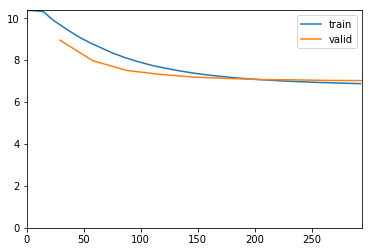

shuffle
shuffle
shuffle
shuffle
shuffle
shuffle
shuffle
shuffle
shuffle
CPU times: user 4h 3min 49s, sys: 12min 28s, total: 4h 16min 18s
Wall time: 1h 17min 34s
2 nb: used GB memory: 10.25
1339


In [22]:
print(gc.collect())
print("1 nb: used GB memory:", usedGB_RAM()) 
%time learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))
print("2 nb: used GB memory:", usedGB_RAM()) 
print(gc.collect())